# Выявление поведения лосс и функции энергии

In [20]:
import albumentations as A
from torch.utils.data import DataLoader, random_split

from src.config import MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN
from src.train import get_dataset, get_loaders
from src.train.utils import get_config, get_experiments, get_model, display_images
from src.transforms import get_norm_transform, get_resize_transform
from tqdm import tqdm
import numpy as np
from src.models import models_list
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt 
from copy import deepcopy
from src.train import ContrastiveLoss
from torch.optim import Adam

In [21]:
basic_cnn = deepcopy(models_list['basic_cnn'])

In [22]:
basic_cnn

SiameseBasicCNN(
  (cnn1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [23]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

In [24]:
# dataset_config = get_config('mot20_ext-v1d')
dataset_config = {
    'dataset_config': 'mot20_ext-v1d',
    'dataset': 'mot20_ext',
    'dataset_use': 0.01,
    'train_proportion': 0.8,
    'val_proportion': 0.2,
    'batch_size': 16,
    'extra_parameters': {
        'visibility_threshold': 1,
        'negative_proportion': 0.5,
        'frame_distance': 0
    }
}

In [25]:
train_loader, val_loader, _ = get_loaders(dataset_config, transform=transform)

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [26]:
len(train_loader), len(val_loader)

(87, 21)

In [27]:
lr = 1e-3
criterion = ContrastiveLoss()
optimizer = Adam(basic_cnn.parameters(), lr)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [28]:
basic_cnn = basic_cnn.to(device)

losses_train = []
accuracies_train = []
losses_val = []
accuracies_val = []

for epoch in range(5):
    for phase in ['train', 'val']:
        if (phase == 'train'):
            dataloader = train_loader
            # if (scheduler is not None):
            #     scheduler.step()
            basic_cnn.train()
        else:
            dataloader = val_loader
            basic_cnn.eval()
        running_loss = 0.
        running_acc = 0.
        for (x1, x2, y) in tqdm(dataloader):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                distance = basic_cnn(x1, x2)
                loss = criterion(distance, y)
                if (phase == 'train'):
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item()
            # print(distance)
            # считаем аккураси. все что больше тресхолда - 1, меньше - 0
            # d = distance.clone().cpu()
            # d = d.detach().numpy()
            # d = (d - d. min()) / (d. max() - d. min())
            # print(d)
            # running_acc += get_distance_accuracy(
            #     distance.clone(), y, threshold)
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        if phase == 'val':
            losses_val.append(epoch_loss)
            # accuracies_val.append(epoch_acc)
        else:
            losses_train.append(epoch_loss)
            # accuracies_train.append(epoch_acc)

100%|██████████| 21/21 [00:01<00:00, 20.43it/s]


In [29]:
losses_val

[1.6299123707271757,
 1.5539838331086295,
 1.5531728778566634,
 1.5929772513253349,
 1.5837208770570301]

## Проверим что модель выдаст на валидации после обучения

In [30]:
distances = []
for x1, x2, y in tqdm(val_loader):
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    # нам не нужно считать градиент для предсказания
    with torch.no_grad():
        d = basic_cnn(x1, x2)
    # убираем из видеопамяти
    distances.append((d.cpu(), y.cpu()))
    # удаляем
    del d
    del y
    # очищаем кэш
    torch.cuda.empty_cache()
    # d = 1 if (d > threshold) else 0

# acc = acc / len(test_loader)

100%|██████████| 21/21 [00:01<00:00, 20.57it/s]


In [31]:
distances[0][1].shape

torch.Size([16])

In [32]:
distances[0][0].reshape(1, 16)[0].shape

torch.Size([16])

In [33]:
len(distances[0][0])

16

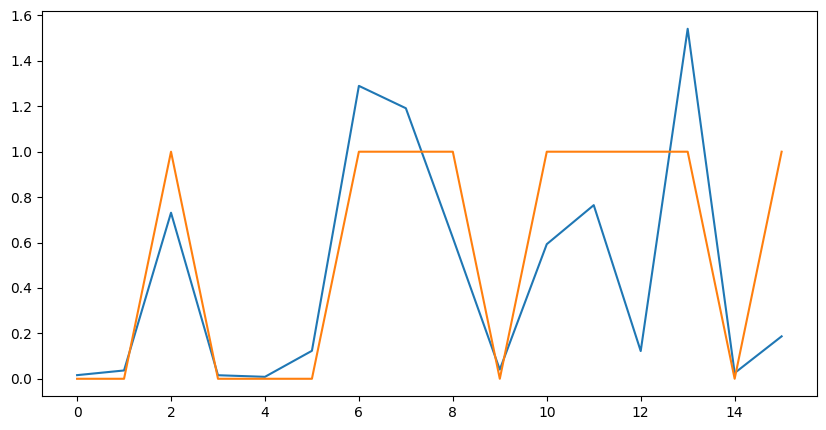

In [34]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(range(len(distances[0][0])), distances[0][0].reshape(1, 16)[0].numpy(), distances[0][1].numpy())

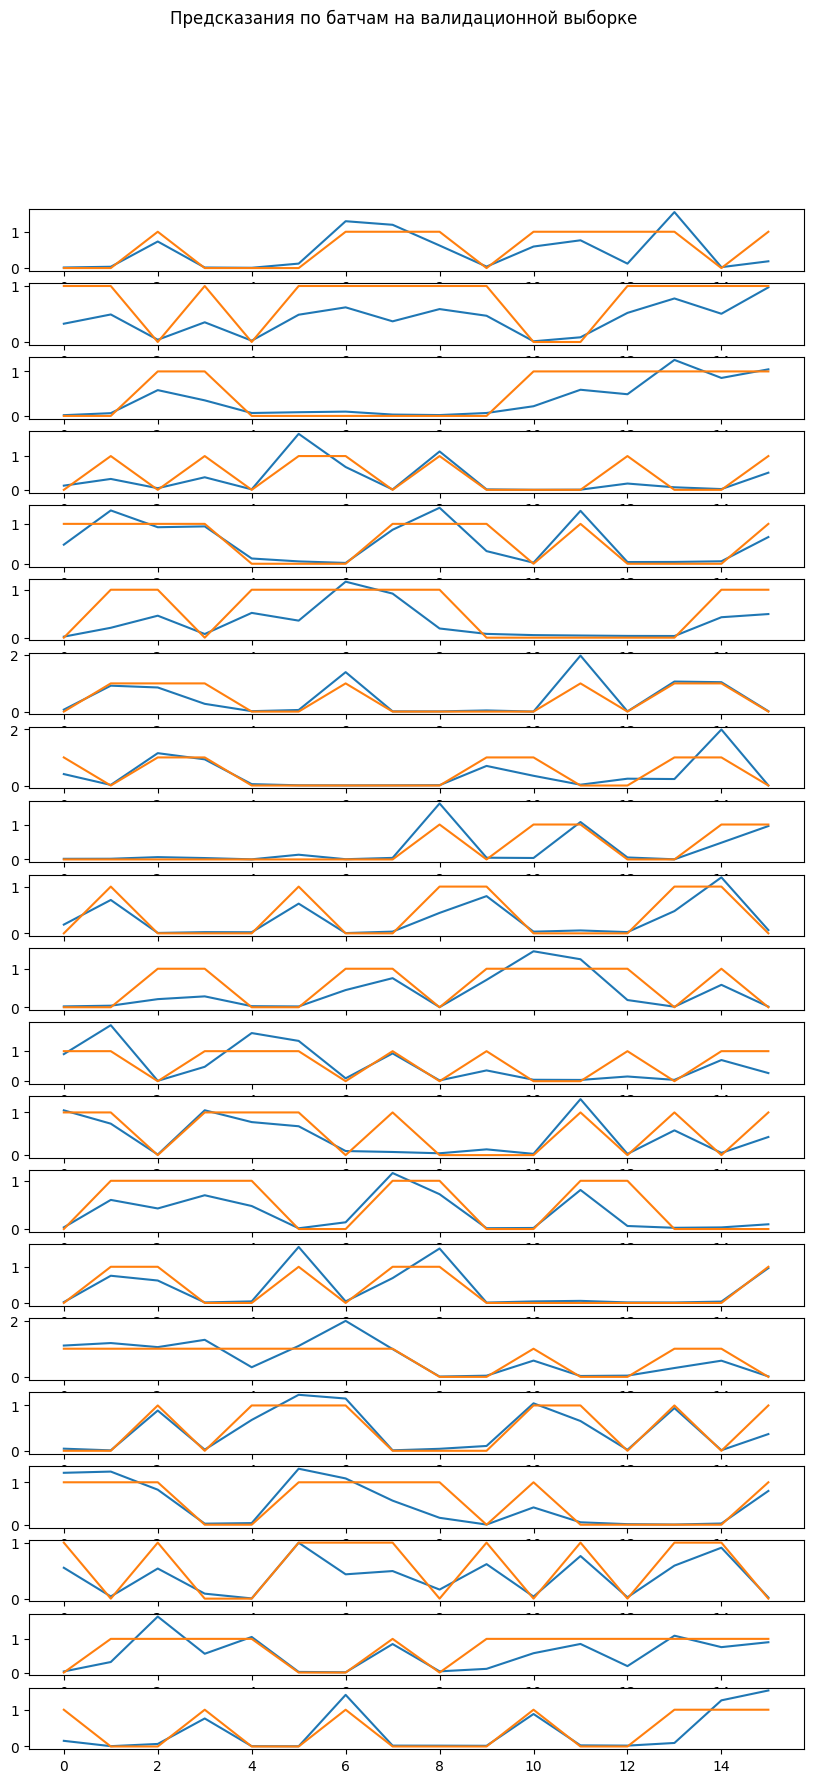

In [35]:
plt.rcParams['figure.figsize'] = [10, 20]
fig, axs = plt.subplots(len(distances))
fig.suptitle('Предсказания по батчам на валидационной выборке')
for batch, i in zip(distances, range(len(distances))):
    axs[i].plot(range(len(batch[0])), batch[0].reshape(1, 16)[0].numpy(), batch[1].numpy())

In [36]:
plt.rcParams['figure.figsize'] = [10, 5]

## Анализ объектов с кривым результатом

## Анализ на тесте

In [37]:
test_dataset_config = get_config('mot20_ext-test-v2')
test_dataset_config

{'dataset_config': 'mot20_ext-test-v2',
 'dataset': 'mot20_ext_test',
 'dataset_use': 0.1,
 'train_proportion': 1.0,
 'val_proportion': 0.0,
 'test_proportion': 0.0,
 'batch_size': 1,
 'extra_parameters': {'visibility_threshold': 1.0,
  'negative_proportion': 0.5,
  'frame_distance': 0}}

In [38]:
test_set, _ = random_split(get_dataset(test_dataset_config, transform), [
                          test_dataset_config['dataset_use'], 1 - test_dataset_config['dataset_use']])

In [39]:
test_loader = DataLoader(test_set)
len(test_loader)

6946

In [40]:
test_distances = []
for x1, x2, y in tqdm(test_loader):
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    # нам не нужно считать градиент для предсказания
    with torch.no_grad():
        d = basic_cnn(x1, x2)
    # убираем из видеопамяти
    test_distances.append((d.cpu(), y.cpu()))
    # удаляем
    del d
    del y
    # очищаем кэш
    torch.cuda.empty_cache()
    # d = 1 if (d > threshold) else 0

# acc = acc / len(test_loader)

100%|██████████| 6946/6946 [00:27<00:00, 248.92it/s]


In [81]:
d = torch.tensor(test_distances[:100])
d.shape
res = d.T

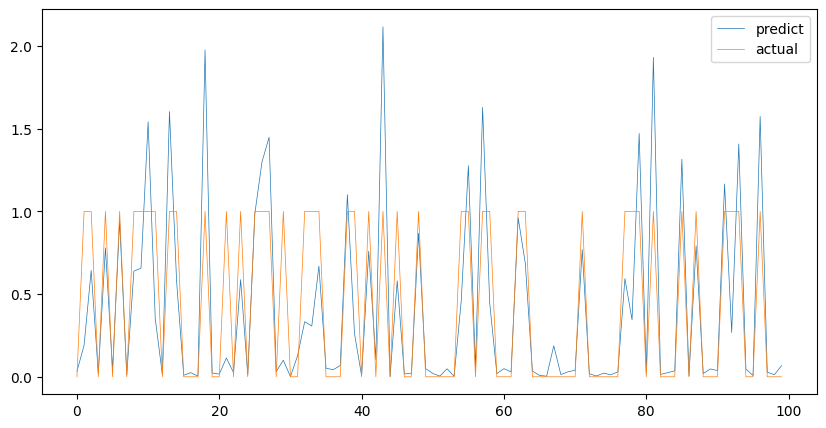

In [82]:
plt.plot(range(res.shape[1]), np.array(res[0]), np.array(res[1]), linewidth=0.5)
plt.legend(['predict', 'actual'])

In [77]:
d = torch.tensor(test_distances[:100])
d.shape

torch.Size([100, 2])

tensor([[3.2665e-02, 1.9038e-01, 6.4244e-01, 2.0405e-02, 7.7949e-01, 4.3615e-02,
         9.4166e-01, 1.0943e-02, 6.3870e-01, 6.5638e-01, 1.5419e+00, 3.5207e-01,
         1.4530e-02, 1.6035e+00, 5.7863e-01, 9.2759e-03, 2.4940e-02, 4.1356e-03,
         1.9763e+00, 2.2078e-02, 1.6363e-02, 1.1366e-01, 2.5299e-02, 5.8748e-01,
         1.1681e-02, 9.8798e-01, 1.2987e+00, 1.4482e+00, 3.1599e-02, 1.0019e-01,
         9.6451e-04, 1.2701e-01, 3.3298e-01, 3.0712e-01, 6.6956e-01, 5.1940e-02,
         4.2619e-02, 6.7650e-02, 1.1017e+00, 2.6125e-01, 5.5603e-03, 7.5931e-01,
         1.0453e-01, 2.1161e+00, 1.1556e-03, 5.8053e-01, 1.6750e-02, 2.1345e-02,
         8.6784e-01, 4.9496e-02, 2.0158e-02, 4.1086e-03, 4.8308e-02, 3.2705e-03,
         4.6058e-01, 1.2760e+00, 5.3834e-02, 1.6287e+00, 4.4507e-01, 1.9463e-02,
         4.9012e-02, 2.9285e-02, 9.6111e-01, 6.8588e-01, 3.4600e-02, 8.3566e-03,
         3.3921e-03, 1.8737e-01, 1.3107e-02, 3.0099e-02, 3.9315e-02, 7.6902e-01,
         1.8126e-02, 4.5291e

## Анализ по классам